<link rel="stylesheet" href="/site-assets/css/gemma.css">
<link rel="stylesheet" href="https://fonts.googleapis.com/css2?family=Google+Symbols:opsz,wght,FILL,GRAD@20..48,100..700,0..1,-50..200" />

# Health Assistanace through Fine-Tuned LoRA-Based Language Models

Aayush Adhikari

220426@softwarica.edu.np

Coventry ID :13898296

## Overview

Gemma is a family of lightweight, state-of-the-art open models developed using the same research and technology behind the Gemini models.

Large Language Models (LLMs) like Gemma excel at various natural language processing (NLP) tasks. These models undergo pre-training on vast text corpora in a self-supervised manner, allowing them to learn general knowledge, such as statistical word relationships. They can then be fine-tuned with domain-specific data to perform specialized tasks like sentiment analysis.

Since LLMs contain billions of parameters, full fine-tuning is often unnecessary, as fine-tuning datasets are significantly smaller than pre-training datasets.

Low-Rank Adaptation (LoRA) is an efficient fine-tuning technique that minimizes the number of trainable parameters by freezing the model’s original weights and integrating a small set of additional weights. This approach accelerates training, reduces memory usage, and produces smaller model weights (a few hundred megabytes), all while preserving output quality.

## Setup

### Get access to Gemma

To complete this tutorial, we will first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show us how to do the following:

* Get access to Gemma on [kaggle.com](https://kaggle.com).
* Select a Colab runtime with sufficient resources to run
  the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After we have completed the Gemma setup, we have to move on to the next section, where we will set environment variables for your Colab environment.

### Select the runtime

To complete this tutorial, we will need to have a Colab runtime with sufficient resources to run the Gemma model. In this case, we can use a T4 GPU:

1. In the upper-right of the Colab window, we have to select &#9662; (**Additional connection options**).
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Configure API key

To use Gemma, we must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, we have go to the **Account** tab of our Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing our API credentials.

In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. We have to store our username under the name `KAGGLE_USERNAME` and our API key under the name `KAGGLE_KEY`.

### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [1]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

### Install dependencies

Install Keras, KerasNLP, and other dependencies.

In [2]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U "keras>=3"
!pip install tensorflow-text
!pip install tensorflow-hub
!pip install keras-hub


### Select a backend

Keras is a high-level deep learning API designed for ease of use and compatibility across multiple frameworks. With Keras 3, you can run workflows using one of three backends: TensorFlow, JAX, or PyTorch.

In this tutorial, set JAX as the backend.

In [3]:
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Import packages

Import Keras and KerasNLP.

In [4]:
import keras
import keras_nlp


In [5]:
print(keras.__version__)
print(keras_nlp.__version__)

3.8.0
0.18.1


## Load Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preprocess the data. This tutorial uses a subset of 1500 training examples to execute the notebook faster. Consider using more training data for higher quality fine-tuning.

In [7]:
import pandas as pd
df = pd.read_json('/content/drive/MyDrive/llm/dataset/newdata.json')
df

,prompt,response
0,How does low food quality impact health?,Consuming low-quality food can lead to malnutr...
1,What foods should a diabetic patient in Kathma...,"Eat fiber-rich foods like whole grains, lentil..."
2,Are there any traditional remedies in Nepal fo...,Some traditional remedies include consuming fe...
3,I often feel dizzy and experience rapid heartb...,"Yes, dizziness and rapid heartbeat can be symp..."
4,I have blurry vision and eye pain. Which speci...,Visit an Ophthalmologist at Tilganga Institute...
...,...,...
1497,I have severe tooth pain and gum bleeding. Whi...,Visit the Dental and Oral Health department at...
1498,Are there any traditional remedies in Nepal fo...,Some traditional remedies include consuming fe...
1499,I feel extremely tired and weak throughout the...,Chronic fatigue is a common symptom of high or...
1500,I often feel dizzy and experience rapid heartb...,"Yes, dizziness and rapid heartbeat can be symp..."


In [8]:
import json
data = []
file  = open("/content/drive/MyDrive/llm/dataset/newdata.json",'r')
for line in file:
    features = json.loads(line)
    print(features)
    for i in features:
      data.append(f"Instruction:\n{i['prompt']}\n\nResponse:\n{i['response']}")


[{'prompt': 'How does low food quality impact health?', 'response': 'Consuming low-quality food can lead to malnutrition, digestive issues, weakened immunity, and long-term health conditions like heart disease and diabetes. Always check food quality before consumption.'}, {'prompt': 'What foods should a diabetic patient in Kathmandu eat to control blood sugar?', 'response': 'Eat fiber-rich foods like whole grains, lentils, and green vegetables. Include lean proteins like fish and chicken. Avoid sugary drinks, white rice, and processed foods. Drink plenty of water and monitor portion sizes.'}, {'prompt': 'Are there any traditional remedies in Nepal for diabetes control?', 'response': 'Some traditional remedies include consuming fenugreek seeds, bitter gourd juice, and neem leaves. However, these should be used as complementary treatments along with a doctor-recommended diabetes management plan.'}, {'prompt': 'I often feel dizzy and experience rapid heartbeat. Could this be related to hi

In [9]:
#Show json data
data

['Instruction:\nHow does low food quality impact health?\n\nResponse:\nConsuming low-quality food can lead to malnutrition, digestive issues, weakened immunity, and long-term health conditions like heart disease and diabetes. Always check food quality before consumption.',
 'Instruction:\nWhat foods should a diabetic patient in Kathmandu eat to control blood sugar?\n\nResponse:\nEat fiber-rich foods like whole grains, lentils, and green vegetables. Include lean proteins like fish and chicken. Avoid sugary drinks, white rice, and processed foods. Drink plenty of water and monitor portion sizes.',
 'Instruction:\nAre there any traditional remedies in Nepal for diabetes control?\n\nResponse:\nSome traditional remedies include consuming fenugreek seeds, bitter gourd juice, and neem leaves. However, these should be used as complementary treatments along with a doctor-recommended diabetes management plan.',
 'Instruction:\nI often feel dizzy and experience rapid heartbeat. Could this be rela

## Load Model

KerasNLP offers implementations of various popular model architectures. In this tutorial, we'll build a model using GemmaCausalLM, a complete Gemma model designed for causal language modeling, where the next token is predicted based on preceding tokens.

Use the from_preset method to create the model:

In [10]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

The `from_preset` method instantiates the model from a preset architecture and weights. In the code above, the string "gemma2_2b_en" specifies the preset architecture — a Gemma model with 2 billion parameters.

## LoRA Fine-tuning

To enhance the model’s responses, fine-tune it with Low Rank Adaptation (LoRA) using the "health assistance dataset for Kathmandu" dataset from Kaggle.

The LoRA rank determines the size of the trainable matrices added to the original LLM weights, influencing both the precision and flexibility of fine-tuning.

A higher rank allows for more detailed adjustments but increases the number of trainable parameters.
A lower rank reduces computational overhead but may limit adaptation precision.
This tutorial uses a LoRA rank of 4. In practice, start with a smaller rank (e.g., 4, 8, or 16) for efficient experimentation. Train and evaluate the model’s performance, then gradually increase the rank if further improvements are needed.

In [11]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.6 billion to 2.9 million).

In [12]:
# Limit the input sequence length to 256 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(data, epochs=5, batch_size=1)

Epoch 1/5
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1283s 829ms/step - loss: 0.2766 - sparse_categorical_accuracy: 0.7148
Epoch 2/5
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1236s 808ms/step - loss: 0.0188 - sparse_categorical_accuracy: 0.9686
Epoch 3/5
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1223s 814ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9692
Epoch 4/5
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1223s 814ms/step - loss: 0.0152 - sparse_categorical_accuracy: 0.9697
Epoch 5/5
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 1223s 814ms/step - loss: 0.0146 - sparse_categorical_accuracy: 0.9704


In [ ]:
# Save the finetuned model
my_model_name = "my_gemma2_pt1"
gemma_lm.save_to_preset(f"/content/drive/MyDrive/llm/{my_model_name}")

### Note on mixed precision fine-tuning on NVIDIA GPUs

For fine-tuning, full precision is recommended. However, when using NVIDIA GPUs, enabling mixed precision (keras.mixed_precision.set_global_policy('mixed_bfloat16')) can accelerate training with minimal impact on quality.

Keep in mind that mixed precision requires more memory, making it beneficial primarily for larger GPUs.


For inference, half-precision (`keras.config.set_floatx("bfloat16")`) will work and save memory while mixed precision is not applicable.

### Prompt

In [31]:
# prompt = template.format(
#     prompt="How much vitamin C is in APPLE, GREEN (EPAL HIJAU) ; PYRUS MALUS?",
#     response="",
# )
prompt="What diseases are caused by air pollution in Kathmandu?"
print(gemma_lm.generate(prompt, max_length=256))

What diseases are caused by air pollution in Kathmandu?

[Answer 1]

Air pollution in Kathmandu causes respiratory diseases like asthma, bronchitis, lung infections, and cardiovascular problems. Prolonged exposure can also lead to cancer.


## Save the model

In [ ]:
my_model_name = "my_gemma2_pt"
gemma_lm.save_to_preset(f"{my_model_name}")

# Accuracy and Loss Plot

In [14]:
history = gemma_lm.history.history
history['epochs'] = [i for i in range(1,6)]

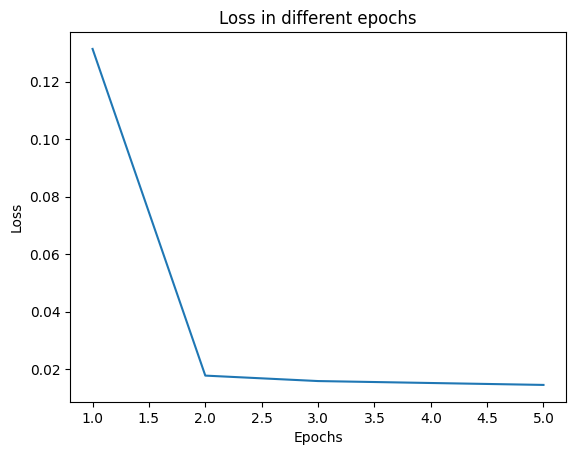

In [15]:
from matplotlib import pyplot as plt
plt.plot(history['epochs'],history['loss'])
plt.title('Loss in different epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

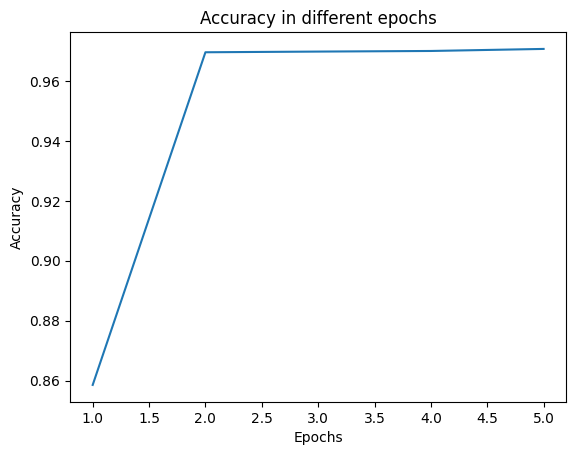

In [16]:
plt.plot(history['epochs'],history['sparse_categorical_accuracy'])
plt.title('Accuracy in different epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()